In [2]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [3]:
path = os.listdir('Unlabel_data_100k/')
Image = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('Unlabel_data_100k/'+str(path_now))
    Image.append(a)

Image = np.asarray(Image)

In [4]:
np.shape(Image)

(100000, 5, 64, 64)

In [5]:
Image = Image.transpose(0,2,3,1)

In [6]:
Image_RGB = Image

In [7]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

20361
31217
56662


In [8]:
np.min(Image_RGB)

-0.21253407

(array([  1.00000000e+00,   3.00000000e+00,   8.00000000e+00,
          3.30000000e+01,   4.40000000e+01,   7.60000000e+01,
          9.40000000e+01,   9.60000000e+01,   1.53000000e+02,
          1.56000000e+02,   2.17000000e+02,   2.20000000e+02,
          2.78000000e+02,   3.00000000e+02,   2.95000000e+02,
          3.26000000e+02,   3.18000000e+02,   3.49000000e+02,
          3.77000000e+02,   3.60000000e+02,   4.26000000e+02,
          4.56000000e+02,   5.47000000e+02,   5.90000000e+02,
          7.62000000e+02,   8.36000000e+02,   9.47000000e+02,
          1.28300000e+03,   1.20200000e+03,   1.40300000e+03,
          1.62900000e+03,   1.68700000e+03,   1.71100000e+03,
          1.83900000e+03,   1.86600000e+03,   1.92200000e+03,
          2.02100000e+03,   2.07200000e+03,   2.21900000e+03,
          2.21100000e+03,   2.37000000e+03,   2.55300000e+03,
          2.74000000e+03,   3.09200000e+03,   3.45700000e+03,
          3.67900000e+03,   4.18300000e+03,   4.61300000e+03,
        

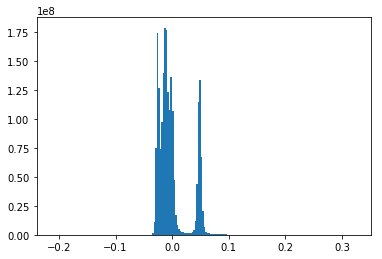

In [9]:
plt.hist(Image_RGB.reshape(-1,),200)

In [10]:
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
print('train_data.shape:',train_data.shape)


train_data.shape: (100000, 64, 64, 5)


In [11]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)

In [12]:
autoencoder.fit(train_data[:100000], train_data[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 169s - loss: 0.2153 - val_loss: 0.1644
Epoch 2/100
80000/80000 [==============================] - 161s - loss: 0.1346 - val_loss: 0.1167
Epoch 3/100
80000/80000 [==============================] - 161s - loss: 0.1191 - val_loss: 0.1116
Epoch 4/100
80000/80000 [==============================] - 161s - loss: 0.1101 - val_loss: 0.1044
Epoch 5/100
80000/80000 [==============================] - 161s - loss: 0.1047 - val_loss: 0.1053
Epoch 6/100
80000/80000 [==============================] - 161s - loss: 0.1013 - val_loss: 0.1055
Epoch 7/100
80000/80000 [==============================] - 161s - loss: 0.0982 - val_loss: 0.0951
Epoch 8/100
80000/80000 [==============================] - 161s - loss: 0.0967 - val_loss: 0.1044
Epoch 9/100
80000/80000 [==============================] - 161s - loss: 0.0948 - val_loss: 0.0893
Epoch 10/100
80000/80000 [==============================] - 161s - l

In [14]:
autoencoder.save_weights('hennanxunliande.h5')

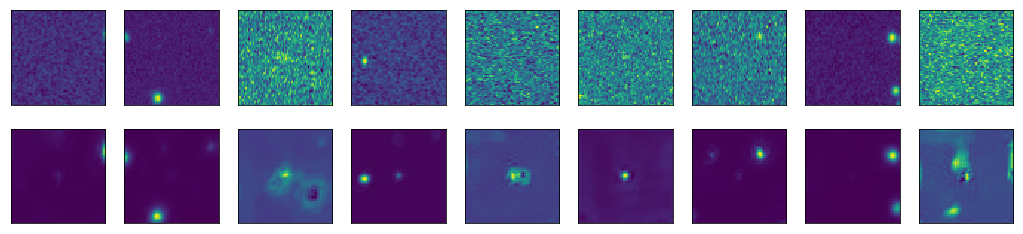

In [15]:
decoded_imgs = autoencoder.predict(train_data[0:100],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:100][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
encoder = Model(inputs=input_img, outputs=encoded)
encoded_variables = encoder.predict(train_data[:100000],batch_size=100)
encoded_variables.shape

(100000, 30)

In [17]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

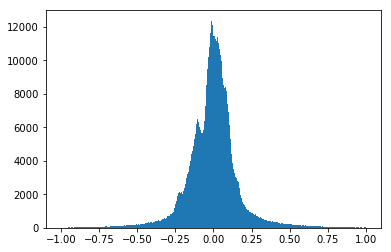

In [18]:
plt.hist(Zero_one_normalized_encoded_variables.reshape(-1,),2000)
plt.show()

In [19]:
Zero_one_normalized_encoded_variables.shape

(100000, 30)

# VAE

In [84]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(0.7)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.005*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [85]:
vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - loss: 2.2257 - val_loss: 1.9424
Epoch 2/100
80000/80000 [==============================] - 3s - loss: 2.0116 - val_loss: 1.8889
Epoch 3/100
80000/80000 [==============================] - 3s - loss: 1.9880 - val_loss: 1.8850
Epoch 4/100
80000/80000 [==============================] - 3s - loss: 1.9852 - val_loss: 1.8838
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 1.9836 - val_loss: 1.8834
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9825 - val_loss: 1.8807
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9817 - val_loss: 1.8809
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9809 - val_loss: 1.8810
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9804 - val_loss: 1.8791
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9799 - val_lo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


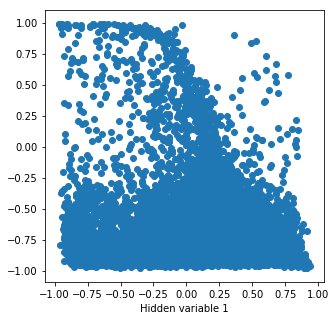

In [86]:
lower_lim = 0
upper_lim = 100000

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)


plt.figure(figsize=(5, 5))
plt.scatter(x_vis[:, 0] ,x_vis[:, 1])
plt.xlabel("Hidden variable 1")

plt.show()

In [171]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(0.7)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.05*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [172]:
vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - loss: 2.1762 - val_loss: 1.8785
Epoch 2/100
80000/80000 [==============================] - 3s - loss: 1.9773 - val_loss: 1.8549
Epoch 3/100
80000/80000 [==============================] - 3s - loss: 1.9546 - val_loss: 1.8385
Epoch 4/100
80000/80000 [==============================] - 3s - loss: 1.9438 - val_loss: 1.8278
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 1.9325 - val_loss: 1.8179
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9217 - val_loss: 1.8115
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9151 - val_loss: 1.8084
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9123 - val_loss: 1.8073
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9099 - val_loss: 1.8075
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9086 - val_lo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


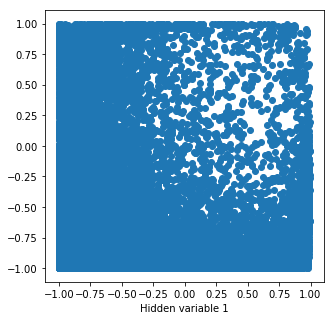

In [186]:
lower_lim = 0
upper_lim = 100000

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)


plt.figure(figsize=(5, 5))
plt.scatter(x_vis[:, 0] ,x_vis[:, 1])
plt.xlabel("Hidden variable 1")

plt.show()

In [45]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

test_Image = []
Class = []

for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        test_Image.append(a[j]['image'])
        Class.append(a[j]['class'])


test_Image = np.asarray(test_Image)
Class = np.asarray(Class)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [46]:
np.shape(test_Image)

(14142, 5, 64, 64)

In [47]:
test_Image_RGB = test_Image.transpose(0,2,3,1)

In [48]:
for i in range(len(test_Image_RGB)):
    if True in np.isnan(test_Image_RGB[i]).reshape(64*64*5):
        print(i)
        test_Image_RGB[i][np.isnan(test_Image_RGB[i])==True]=np.mean(test_Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


test_Image_RGB /= np.max(test_Image_RGB)
test_Image_RGB -= np.mean(test_Image_RGB)
test_Image_RGB = -test_Image_RGB

815


In [50]:
np.min(test_Image_RGB)

-0.071392298

In [174]:
test_encoded_variables = encoder.predict(test_Image_RGB[:10000],batch_size=100)

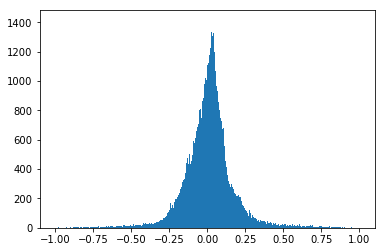

In [175]:
plt.hist(test_encoded_variables.reshape(-1,),2000)
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


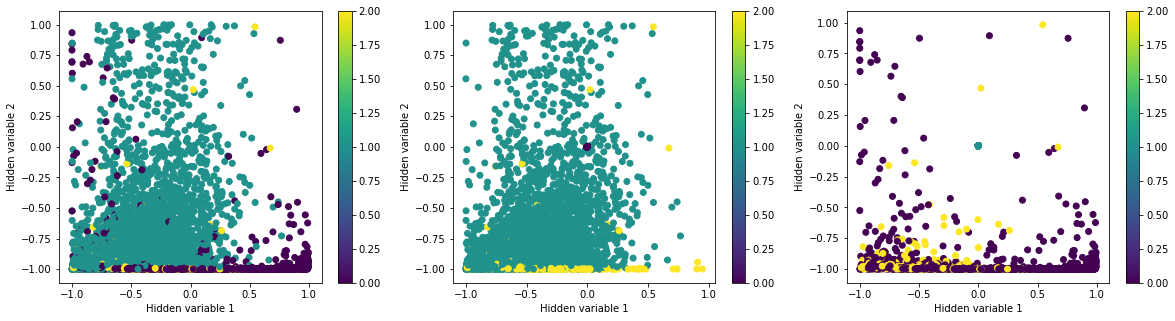

In [187]:
vis = Model(input=net_3_input, output=z_mean)
x_vis = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)

x_vis_1 = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)  
x_vis_1[Class[:10000]<1]=0

x_vis_2 = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)  
x_vis_2[Class[:10000]==1]=0


plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Class[:10000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=Class[:10000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=Class[:10000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()
plt.show()

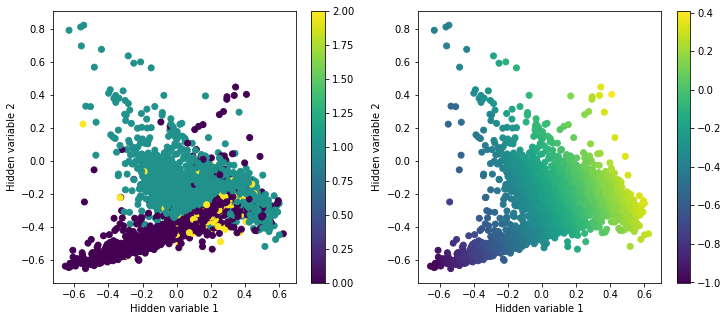

In [129]:
lower_lim = 0
upper_lim = 10000


x_vis = vis.predict(test_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(test_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Class[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [189]:
upper_lim=10000

2200
AUC: 0.892114827072


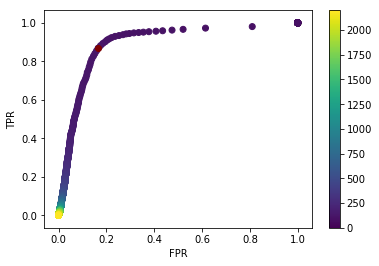

In [190]:
Y_pred = x_vis[:,1]
thr_min = -1.1
thr_max = 1.1
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

In [191]:
AUC = np.zeros((50,))

for xunhuan in range(50):
    """VAE"""
    net_3_input= Input(shape=(30,))
    h_1 = Dense(30, activation='tanh')(net_3_input)

    z_mean = Dense(2,activation='tanh')(h_1)
    z_log_var = Dense(2)(h_1)

    def sampling(args):   
        z_mean, z_log_var = args  
        epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
        return z_mean + K.exp(z_log_var / 2)* epsilon

    z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
    decoded = Dense(30, activation='tanh')(z)


    def vae_loss(x, decoded):
        xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
        #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        m = K.constant(0.7)
        s = K.constant(1)
        #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
        kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
        return 1*xent_loss + 0.05*kl_loss_d1 
    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    vae = Model(input=net_3_input, output=decoded)
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])
    vis = Model(input=net_3_input, output=z_mean)

    # display a 2D plot of the digit classes in the latent space  
    # x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

    test_encoded_variables = encoder.predict(test_Image_RGB[:10000],batch_size=100)
    
    vis = Model(input=net_3_input, output=z_mean)
    x_vis = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)

    upper_lim=10000
    
    Y_pred = x_vis[:,0]
    thr_min = -1.1
    thr_max = 1.1
    test_accuracy = 0.001
    test_range = int((thr_max - thr_min)/test_accuracy)
    print(test_range)
    FP = []
    TP = []
    TN = []
    FN = []
    TA = np.ones((Y_pred.shape[0],))
    TA[Class[lower_lim:upper_lim] ==0 ] = 0
    TA[Class[lower_lim:upper_lim] ==2 ] = 0

    for i in range(test_range):
        FP_temp = np.zeros((Y_pred.shape[0]))
        TP_temp = np.zeros((Y_pred.shape[0]))
        TN_temp = np.zeros((Y_pred.shape[0]))
        FN_temp = np.zeros((Y_pred.shape[0]))
        LA = np.zeros((Y_pred.shape[0],))
        thr_now = thr_min+ i*test_accuracy
        LA[Y_pred[:] > thr_now] = 1
        for j in range(Y_pred.shape[0]):
            if LA[j]==0:
                if TA[j]==1:
                    FN_temp[j] = 1
                else:
                    TN_temp[j] = 1
            else:
                if TA[j] == 1:
                    TP_temp[j] = 1
                else:
                    FP_temp[j] = 1
        FP.append(FP_temp)
        TP.append(TP_temp)
        TN.append(TN_temp)
        FN.append(FN_temp)

    TPR = np.zeros((test_range,))
    FPR = np.zeros((test_range,))
    TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
    FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

    #argmax, OrRed

    AUC[xunhuan] = np.max([np.max([metrics.auc(FPR, TPR),1-metrics.auc(FPR, TPR)]),AUC[xunhuan]])
    
    
    Y_pred = x_vis[:,1]
    thr_min = -1.1
    thr_max = 1.1
    test_accuracy = 0.001
    test_range = int((thr_max - thr_min)/test_accuracy)
    print(test_range)
    FP = []
    TP = []
    TN = []
    FN = []
    TA = np.ones((Y_pred.shape[0],))
    TA[Class[lower_lim:upper_lim] ==0 ] = 0
    TA[Class[lower_lim:upper_lim] ==2 ] = 0

    for i in range(test_range):
        FP_temp = np.zeros((Y_pred.shape[0]))
        TP_temp = np.zeros((Y_pred.shape[0]))
        TN_temp = np.zeros((Y_pred.shape[0]))
        FN_temp = np.zeros((Y_pred.shape[0]))
        LA = np.zeros((Y_pred.shape[0],))
        thr_now = thr_min+ i*test_accuracy
        LA[Y_pred[:] > thr_now] = 1
        for j in range(Y_pred.shape[0]):
            if LA[j]==0:
                if TA[j]==1:
                    FN_temp[j] = 1
                else:
                    TN_temp[j] = 1
            else:
                if TA[j] == 1:
                    TP_temp[j] = 1
                else:
                    FP_temp[j] = 1
        FP.append(FP_temp)
        TP.append(TP_temp)
        TN.append(TN_temp)
        FN.append(FN_temp)

    TPR = np.zeros((test_range,))
    FPR = np.zeros((test_range,))
    TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
    FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

    #argmax, OrRed

    AUC[xunhuan] = np.max([np.max([metrics.auc(FPR, TPR),1-metrics.auc(FPR, TPR)]),AUC[xunhuan]])
    print(AUC[xunhuan])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - loss: 2.2028 - val_loss: 1.8607
Epoch 2/100
80000/80000 [==============================] - 3s - loss: 1.9511 - val_loss: 1.8278
Epoch 3/100
80000/80000 [==============================] - 3s - loss: 1.9370 - val_loss: 1.8246
Epoch 4/100
80000/80000 [==============================] - 3s - loss: 1.9314 - val_loss: 1.8185
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 1.9194 - val_loss: 1.8086
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9127 - val_loss: 1.8073
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9107 - val_loss: 1.8040
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9095 - val_loss: 1.8048
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9089 - val_loss: 1.8024
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9077 - val_lo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


2200
2200
0.879043679012
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - loss: 2.1903 - val_loss: 1.8693
Epoch 2/100
80000/80000 [==============================] - 3s - loss: 1.9397 - val_loss: 1.8171
Epoch 3/100
80000/80000 [==============================] - 3s - loss: 1.9182 - val_loss: 1.8119
Epoch 4/100
80000/80000 [==============================] - 3s - loss: 1.9153 - val_loss: 1.8120
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 1.9142 - val_loss: 1.8111
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9138 - val_loss: 1.8106
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9130 - val_loss: 1.8096
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9121 - val_loss: 1.8058
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9104 - val_loss: 1.8047
Epoch 10/100
80000/80000 [==============================] - 3

80000/80000 [==============================] - 3s - loss: 1.8947 - val_loss: 1.7910
Epoch 29/100
80000/80000 [==============================] - 3s - loss: 1.8940 - val_loss: 1.7912
Epoch 30/100
80000/80000 [==============================] - 3s - loss: 1.8942 - val_loss: 1.7895
Epoch 31/100
80000/80000 [==============================] - 3s - loss: 1.8941 - val_loss: 1.7902
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.8937 - val_loss: 1.7898
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.8939 - val_loss: 1.7908
Epoch 34/100
80000/80000 [==============================] - 3s - loss: 1.8937 - val_loss: 1.7901
Epoch 35/100
80000/80000 [==============================] - 3s - loss: 1.8933 - val_loss: 1.7896
Epoch 36/100
80000/80000 [==============================] - 3s - loss: 1.8930 - val_loss: 1.7898
2200
2200
0.890919953397
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - l

80000/80000 [==============================] - 3s - loss: 1.9150 - val_loss: 1.8110
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9135 - val_loss: 1.8102
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9114 - val_loss: 1.8073
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9099 - val_loss: 1.8051
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9078 - val_loss: 1.8026
Epoch 11/100
80000/80000 [==============================] - 3s - loss: 1.9059 - val_loss: 1.8007
Epoch 12/100
80000/80000 [==============================] - 3s - loss: 1.9042 - val_loss: 1.7977
Epoch 13/100
80000/80000 [==============================] - 3s - loss: 1.9025 - val_loss: 1.7969
Epoch 14/100
80000/80000 [==============================] - 3s - loss: 1.9011 - val_loss: 1.7962
Epoch 15/100
80000/80000 [==============================] - 3s - loss: 1.8999 - val_loss: 1.7956
Epoch 16/100
80000/80000 [====================

80000/80000 [==============================] - 3s - loss: 1.8945 - val_loss: 1.7909
Epoch 43/100
80000/80000 [==============================] - 3s - loss: 1.8941 - val_loss: 1.7889
Epoch 44/100
80000/80000 [==============================] - 3s - loss: 1.8938 - val_loss: 1.7907
Epoch 45/100
80000/80000 [==============================] - 3s - loss: 1.8946 - val_loss: 1.7894
Epoch 46/100
80000/80000 [==============================] - 3s - loss: 1.8939 - val_loss: 1.7898
Epoch 47/100
80000/80000 [==============================] - 3s - loss: 1.8937 - val_loss: 1.7895
Epoch 48/100
80000/80000 [==============================] - 3s - loss: 1.8938 - val_loss: 1.7898
Epoch 49/100
80000/80000 [==============================] - 3s - loss: 1.8937 - val_loss: 1.7902
2200
2200
0.771247356016
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 5s - loss: 2.1990 - val_loss: 1.9100
Epoch 2/100
80000/80000 [==============================] - 3s - lo

80000/80000 [==============================] - 3s - loss: 1.8922 - val_loss: 1.7893
Epoch 77/100
80000/80000 [==============================] - 3s - loss: 1.8920 - val_loss: 1.7886
Epoch 78/100
80000/80000 [==============================] - 3s - loss: 1.8923 - val_loss: 1.7895
Epoch 79/100
80000/80000 [==============================] - 3s - loss: 1.8922 - val_loss: 1.7894
Epoch 80/100
80000/80000 [==============================] - 3s - loss: 1.8920 - val_loss: 1.7877
Epoch 81/100
80000/80000 [==============================] - 3s - loss: 1.8918 - val_loss: 1.7888
Epoch 82/100
80000/80000 [==============================] - 3s - loss: 1.8922 - val_loss: 1.7896
Epoch 83/100
80000/80000 [==============================] - 3s - loss: 1.8922 - val_loss: 1.7886
Epoch 84/100
80000/80000 [==============================] - 3s - loss: 1.8915 - val_loss: 1.7894
Epoch 85/100
80000/80000 [==============================] - 3s - loss: 1.8921 - val_loss: 1.7886
Epoch 86/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.9028 - val_loss: 1.7992
Epoch 21/100
80000/80000 [==============================] - 3s - loss: 1.9013 - val_loss: 1.7982
Epoch 22/100
80000/80000 [==============================] - 3s - loss: 1.9011 - val_loss: 1.7969
Epoch 23/100
80000/80000 [==============================] - 3s - loss: 1.8998 - val_loss: 1.7964
Epoch 24/100
80000/80000 [==============================] - 3s - loss: 1.8989 - val_loss: 1.7959
Epoch 25/100
80000/80000 [==============================] - 3s - loss: 1.8981 - val_loss: 1.7962
Epoch 26/100
80000/80000 [==============================] - 3s - loss: 1.8977 - val_loss: 1.7934
Epoch 27/100
80000/80000 [==============================] - 3s - loss: 1.8973 - val_loss: 1.7935
Epoch 28/100
80000/80000 [==============================] - 3s - loss: 1.8966 - val_loss: 1.7945
Epoch 29/100
80000/80000 [==============================] - 3s - loss: 1.8965 - val_loss: 1.7941
Epoch 30/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.8982 - val_loss: 1.7941
Epoch 25/100
80000/80000 [==============================] - 3s - loss: 1.8976 - val_loss: 1.7933
Epoch 26/100
80000/80000 [==============================] - 3s - loss: 1.8971 - val_loss: 1.7918
Epoch 27/100
80000/80000 [==============================] - 3s - loss: 1.8970 - val_loss: 1.7933
Epoch 28/100
80000/80000 [==============================] - 3s - loss: 1.8963 - val_loss: 1.7928
Epoch 29/100
80000/80000 [==============================] - 3s - loss: 1.8966 - val_loss: 1.7919
Epoch 30/100
80000/80000 [==============================] - 3s - loss: 1.8961 - val_loss: 1.7933
Epoch 31/100
80000/80000 [==============================] - 3s - loss: 1.8962 - val_loss: 1.7921
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.8956 - val_loss: 1.7917
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.8958 - val_loss: 1.7912
Epoch 34/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.8962 - val_loss: 1.7915
Epoch 21/100
80000/80000 [==============================] - 3s - loss: 1.8963 - val_loss: 1.7914
Epoch 22/100
80000/80000 [==============================] - 3s - loss: 1.8957 - val_loss: 1.7917
Epoch 23/100
80000/80000 [==============================] - 3s - loss: 1.8955 - val_loss: 1.7919
Epoch 24/100
80000/80000 [==============================] - 3s - loss: 1.8958 - val_loss: 1.7909
Epoch 25/100
80000/80000 [==============================] - 3s - loss: 1.8948 - val_loss: 1.7909
Epoch 26/100
80000/80000 [==============================] - 3s - loss: 1.8950 - val_loss: 1.7904
Epoch 27/100
80000/80000 [==============================] - 3s - loss: 1.8949 - val_loss: 1.7900
Epoch 28/100
80000/80000 [==============================] - 3s - loss: 1.8950 - val_loss: 1.7916
Epoch 29/100
80000/80000 [==============================] - 3s - loss: 1.8948 - val_loss: 1.7897
Epoch 30/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.9728 - val_loss: 1.8694
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9734 - val_loss: 1.8690
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9736 - val_loss: 1.8691
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9723 - val_loss: 1.8701
Epoch 11/100
80000/80000 [==============================] - 3s - loss: 1.9726 - val_loss: 1.8690
Epoch 12/100
80000/80000 [==============================] - 3s - loss: 1.9725 - val_loss: 1.8681
Epoch 13/100
80000/80000 [==============================] - 3s - loss: 1.9719 - val_loss: 1.8674
Epoch 14/100
80000/80000 [==============================] - 3s - loss: 1.9720 - val_loss: 1.8672
Epoch 15/100
80000/80000 [==============================] - 3s - loss: 1.9717 - val_loss: 1.8673
Epoch 16/100
80000/80000 [==============================] - 3s - loss: 1.9718 - val_loss: 1.8667
Epoch 17/100
80000/80000 [===================

80000/80000 [==============================] - 3s - loss: 1.8948 - val_loss: 1.7900
Epoch 26/100
80000/80000 [==============================] - 3s - loss: 1.8936 - val_loss: 1.7902
Epoch 27/100
80000/80000 [==============================] - 3s - loss: 1.8939 - val_loss: 1.7910
Epoch 28/100
80000/80000 [==============================] - 3s - loss: 1.8935 - val_loss: 1.7913
Epoch 29/100
80000/80000 [==============================] - 3s - loss: 1.8937 - val_loss: 1.7881
Epoch 30/100
80000/80000 [==============================] - 3s - loss: 1.8934 - val_loss: 1.7902
Epoch 31/100
80000/80000 [==============================] - 3s - loss: 1.8939 - val_loss: 1.7904
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.8935 - val_loss: 1.7889
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.8928 - val_loss: 1.7902
Epoch 34/100
80000/80000 [==============================] - 3s - loss: 1.8929 - val_loss: 1.7902
Epoch 35/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.8942 - val_loss: 1.7909
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.8940 - val_loss: 1.7902
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.8936 - val_loss: 1.7903
Epoch 34/100
80000/80000 [==============================] - 3s - loss: 1.8942 - val_loss: 1.7905
Epoch 35/100
80000/80000 [==============================] - 3s - loss: 1.8935 - val_loss: 1.7903
Epoch 36/100
80000/80000 [==============================] - 3s - loss: 1.8933 - val_loss: 1.7907
Epoch 37/100
80000/80000 [==============================] - 3s - loss: 1.8932 - val_loss: 1.7899
Epoch 38/100
80000/80000 [==============================] - 3s - loss: 1.8932 - val_loss: 1.7902
Epoch 39/100
80000/80000 [==============================] - 3s - loss: 1.8930 - val_loss: 1.7907
Epoch 40/100
80000/80000 [==============================] - 3s - loss: 1.8934 - val_loss: 1.7901
Epoch 41/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.9145 - val_loss: 1.8081
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 1.9138 - val_loss: 1.8079
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9124 - val_loss: 1.8066
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9111 - val_loss: 1.8070
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9098 - val_loss: 1.8032
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9075 - val_loss: 1.8034
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9066 - val_loss: 1.8007
Epoch 11/100
80000/80000 [==============================] - 3s - loss: 1.9039 - val_loss: 1.7979
Epoch 12/100
80000/80000 [==============================] - 3s - loss: 1.9016 - val_loss: 1.7968
Epoch 13/100
80000/80000 [==============================] - 3s - loss: 1.9004 - val_loss: 1.7945
Epoch 14/100
80000/80000 [======================

80000/80000 [==============================] - 3s - loss: 1.9116 - val_loss: 1.8075
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9113 - val_loss: 1.8059
Epoch 11/100
80000/80000 [==============================] - 3s - loss: 1.9101 - val_loss: 1.8066
Epoch 12/100
80000/80000 [==============================] - 3s - loss: 1.9088 - val_loss: 1.8061
Epoch 13/100
80000/80000 [==============================] - 3s - loss: 1.9084 - val_loss: 1.8042
Epoch 14/100
80000/80000 [==============================] - 3s - loss: 1.9070 - val_loss: 1.8032
Epoch 15/100
80000/80000 [==============================] - 3s - loss: 1.9060 - val_loss: 1.8015
Epoch 16/100
80000/80000 [==============================] - 3s - loss: 1.9041 - val_loss: 1.7987
Epoch 17/100
80000/80000 [==============================] - 3s - loss: 1.9025 - val_loss: 1.7968
Epoch 18/100
80000/80000 [==============================] - 3s - loss: 1.9008 - val_loss: 1.7960
Epoch 19/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.9030 - val_loss: 1.7969
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9022 - val_loss: 1.7981
Epoch 11/100
80000/80000 [==============================] - 3s - loss: 1.9002 - val_loss: 1.7950
Epoch 12/100
80000/80000 [==============================] - 3s - loss: 1.8997 - val_loss: 1.7954
Epoch 13/100
80000/80000 [==============================] - 3s - loss: 1.8981 - val_loss: 1.7953
Epoch 14/100
80000/80000 [==============================] - 3s - loss: 1.8986 - val_loss: 1.7937
Epoch 15/100
80000/80000 [==============================] - 3s - loss: 1.8974 - val_loss: 1.7940
Epoch 16/100
80000/80000 [==============================] - 3s - loss: 1.8965 - val_loss: 1.7930
Epoch 17/100
80000/80000 [==============================] - 3s - loss: 1.8962 - val_loss: 1.7932
Epoch 18/100
80000/80000 [==============================] - 3s - loss: 1.8961 - val_loss: 1.7915
Epoch 19/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.9764 - val_loss: 1.8706
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9744 - val_loss: 1.8700
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9741 - val_loss: 1.8700
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9731 - val_loss: 1.8699
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9730 - val_loss: 1.8695
Epoch 11/100
80000/80000 [==============================] - 3s - loss: 1.9731 - val_loss: 1.8690
Epoch 12/100
80000/80000 [==============================] - 3s - loss: 1.9722 - val_loss: 1.8690
Epoch 13/100
80000/80000 [==============================] - 3s - loss: 1.9720 - val_loss: 1.8677
Epoch 14/100
80000/80000 [==============================] - 3s - loss: 1.9716 - val_loss: 1.8676
Epoch 15/100
80000/80000 [==============================] - 3s - loss: 1.9711 - val_loss: 1.8658
Epoch 16/100
80000/80000 [====================

80000/80000 [==============================] - 3s - loss: 1.9699 - val_loss: 1.8650
Epoch 25/100
80000/80000 [==============================] - 3s - loss: 1.9692 - val_loss: 1.8669
Epoch 26/100
80000/80000 [==============================] - 3s - loss: 1.9688 - val_loss: 1.8645
Epoch 27/100
80000/80000 [==============================] - 3s - loss: 1.9681 - val_loss: 1.8649
Epoch 28/100
80000/80000 [==============================] - 3s - loss: 1.9677 - val_loss: 1.8638
Epoch 29/100
80000/80000 [==============================] - 3s - loss: 1.9641 - val_loss: 1.8586
Epoch 30/100
80000/80000 [==============================] - 3s - loss: 1.9524 - val_loss: 1.8341
Epoch 31/100
80000/80000 [==============================] - 3s - loss: 1.9219 - val_loss: 1.8082
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.9080 - val_loss: 1.8027
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.9034 - val_loss: 1.8000
Epoch 34/100
80000/80000 [=================

80000/80000 [==============================] - 3s - loss: 1.9653 - val_loss: 1.8619
Epoch 26/100
80000/80000 [==============================] - 3s - loss: 1.9646 - val_loss: 1.8615
Epoch 27/100
80000/80000 [==============================] - 3s - loss: 1.9651 - val_loss: 1.8596
Epoch 28/100
80000/80000 [==============================] - 3s - loss: 1.9650 - val_loss: 1.8631
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.9646 - val_loss: 1.8612
Epoch 30/100
80000/80000 [==============================] - 4s - loss: 1.9645 - val_loss: 1.8611
Epoch 31/100
80000/80000 [==============================] - 3s - loss: 1.9648 - val_loss: 1.8606
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.9647 - val_loss: 1.8608
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.9645 - val_loss: 1.8628
2200
2200
0.882481452748
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 5s - l

80000/80000 [==============================] - 3s - loss: 1.9181 - val_loss: 1.8083
Epoch 31/100
80000/80000 [==============================] - 3s - loss: 1.9074 - val_loss: 1.8020
Epoch 32/100
80000/80000 [==============================] - 3s - loss: 1.9034 - val_loss: 1.7987
Epoch 33/100
80000/80000 [==============================] - 3s - loss: 1.9014 - val_loss: 1.7980
Epoch 34/100
80000/80000 [==============================] - 4s - loss: 1.8994 - val_loss: 1.7954
Epoch 35/100
80000/80000 [==============================] - 4s - loss: 1.8987 - val_loss: 1.7942
Epoch 36/100
80000/80000 [==============================] - 3s - loss: 1.8974 - val_loss: 1.7952
Epoch 37/100
80000/80000 [==============================] - 3s - loss: 1.8970 - val_loss: 1.7932
Epoch 38/100
80000/80000 [==============================] - 3s - loss: 1.8963 - val_loss: 1.7933
Epoch 39/100
80000/80000 [==============================] - 3s - loss: 1.8958 - val_loss: 1.7923
Epoch 40/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9659 - val_loss: 1.8626
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.9656 - val_loss: 1.8627
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.9655 - val_loss: 1.8623
2200
2200
0.888899658809
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s - loss: 2.2261 - val_loss: 1.9181
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 2.0213 - val_loss: 1.8991
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 2.0022 - val_loss: 1.8859
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9852 - val_loss: 1.8745
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9773 - val_loss: 1.8703
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9746 - val_loss: 1.8702
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1

80000/80000 [==============================] - 4s - loss: 1.8923 - val_loss: 1.7894
Epoch 82/100
80000/80000 [==============================] - 3s - loss: 1.8922 - val_loss: 1.7892
2200
2200
0.895502156385
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s - loss: 2.1909 - val_loss: 1.8613
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9454 - val_loss: 1.8199
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9225 - val_loss: 1.8110
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9142 - val_loss: 1.8088
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9111 - val_loss: 1.8069
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9103 - val_loss: 1.8052
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1.9092 - val_loss: 1.8034
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.

80000/80000 [==============================] - 4s - loss: 1.8942 - val_loss: 1.7896
Epoch 39/100
80000/80000 [==============================] - 4s - loss: 1.8934 - val_loss: 1.7905
Epoch 40/100
80000/80000 [==============================] - 4s - loss: 1.8938 - val_loss: 1.7902
Epoch 41/100
80000/80000 [==============================] - 4s - loss: 1.8937 - val_loss: 1.7905
Epoch 42/100
80000/80000 [==============================] - 4s - loss: 1.8934 - val_loss: 1.7897
Epoch 43/100
80000/80000 [==============================] - 4s - loss: 1.8933 - val_loss: 1.7897
2200
2200
0.765688765047
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 7s - loss: 2.1649 - val_loss: 1.8978
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9871 - val_loss: 1.8767
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9764 - val_loss: 1.8707
Epoch 4/100
80000/80000 [==============================] - 4s - loss

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s - loss: 2.1203 - val_loss: 1.8279
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9215 - val_loss: 1.8124
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9144 - val_loss: 1.8103
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9143 - val_loss: 1.8100
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9132 - val_loss: 1.8090
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9120 - val_loss: 1.8079
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1.9120 - val_loss: 1.8052
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.9103 - val_loss: 1.8065
Epoch 9/100
80000/80000 [==============================] - 4s - loss: 1.9097 - val_loss: 1.8054
Epoch 10/100
80000/80000 [==============================] - 4s - loss: 1.9088 - val_lo

80000/80000 [==============================] - 4s - loss: 1.9030 - val_loss: 1.7983
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.9023 - val_loss: 1.7972
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.9005 - val_loss: 1.7957
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8993 - val_loss: 1.7934
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8986 - val_loss: 1.7922
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8977 - val_loss: 1.7926
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8970 - val_loss: 1.7925
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8969 - val_loss: 1.7923
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8962 - val_loss: 1.7931
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7922
Epoch 26/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9733 - val_loss: 1.8708
Epoch 10/100
80000/80000 [==============================] - 4s - loss: 1.9727 - val_loss: 1.8674
Epoch 11/100
80000/80000 [==============================] - 4s - loss: 1.9710 - val_loss: 1.8672
Epoch 12/100
80000/80000 [==============================] - 4s - loss: 1.9703 - val_loss: 1.8667
Epoch 13/100
80000/80000 [==============================] - 4s - loss: 1.9691 - val_loss: 1.8642
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.9696 - val_loss: 1.8642
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.9687 - val_loss: 1.8637
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.9676 - val_loss: 1.8647
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.9677 - val_loss: 1.8638
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.9676 - val_loss: 1.8672
Epoch 19/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8974 - val_loss: 1.7945
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8968 - val_loss: 1.7932
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8961 - val_loss: 1.7924
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8958 - val_loss: 1.7928
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8952 - val_loss: 1.7919
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8949 - val_loss: 1.7917
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7918
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7919
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8945 - val_loss: 1.7915
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8945 - val_loss: 1.7904
Epoch 26/100
80000/80000 [=================

In [192]:
AUC_2 = np.zeros((50,))

for xunhuan in range(50):
    """VAE"""
    net_3_input= Input(shape=(30,))
    h_1 = Dense(30, activation='tanh')(net_3_input)

    z_mean = Dense(2,activation='tanh')(h_1)
    z_log_var = Dense(2)(h_1)

    def sampling(args):   
        z_mean, z_log_var = args  
        epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
        return z_mean + K.exp(z_log_var / 2)* epsilon

    z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
    decoded = Dense(30, activation='tanh')(z)


    def vae_loss(x, decoded):
        xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
        #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        m = K.constant(0.7)
        s = K.constant(1)
        #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
        kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
        return 1*xent_loss + 0.05*kl_loss_d1 
    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    vae = Model(input=net_3_input, output=decoded)
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])
    vis = Model(input=net_3_input, output=z_mean)

    # display a 2D plot of the digit classes in the latent space  
    # x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

    test_encoded_variables = encoder.predict(test_Image_RGB[:10000],batch_size=100)
    
    vis = Model(input=net_3_input, output=z_mean)
    x_vis = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)

    upper_lim=10000
    
    Y_pred = x_vis[:,0]
    thr_min = -1.1
    thr_max = 1.1
    test_accuracy = 0.001
    test_range = int((thr_max - thr_min)/test_accuracy)
    print(test_range)
    FP = []
    TP = []
    TN = []
    FN = []
    TA = np.ones((Y_pred.shape[0],))
    TA[Class[lower_lim:upper_lim] ==0 ] = 0
    TA[Class[lower_lim:upper_lim] ==2 ] = 0

    for i in range(test_range):
        FP_temp = np.zeros((Y_pred.shape[0]))
        TP_temp = np.zeros((Y_pred.shape[0]))
        TN_temp = np.zeros((Y_pred.shape[0]))
        FN_temp = np.zeros((Y_pred.shape[0]))
        LA = np.zeros((Y_pred.shape[0],))
        thr_now = thr_min+ i*test_accuracy
        LA[Y_pred[:] > thr_now] = 1
        for j in range(Y_pred.shape[0]):
            if LA[j]==0:
                if TA[j]==1:
                    FN_temp[j] = 1
                else:
                    TN_temp[j] = 1
            else:
                if TA[j] == 1:
                    TP_temp[j] = 1
                else:
                    FP_temp[j] = 1
        FP.append(FP_temp)
        TP.append(TP_temp)
        TN.append(TN_temp)
        FN.append(FN_temp)

    TPR = np.zeros((test_range,))
    FPR = np.zeros((test_range,))
    TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
    FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

    #argmax, OrRed

    AUC_2[xunhuan] = np.max([np.max([metrics.auc(FPR, TPR),1-metrics.auc(FPR, TPR)]),AUC_2[xunhuan]])
    
    
    Y_pred = x_vis[:,1]
    thr_min = -1.1
    thr_max = 1.1
    test_accuracy = 0.001
    test_range = int((thr_max - thr_min)/test_accuracy)
    print(test_range)
    FP = []
    TP = []
    TN = []
    FN = []
    TA = np.ones((Y_pred.shape[0],))
    TA[Class[lower_lim:upper_lim] ==0 ] = 0
    TA[Class[lower_lim:upper_lim] ==2 ] = 0

    for i in range(test_range):
        FP_temp = np.zeros((Y_pred.shape[0]))
        TP_temp = np.zeros((Y_pred.shape[0]))
        TN_temp = np.zeros((Y_pred.shape[0]))
        FN_temp = np.zeros((Y_pred.shape[0]))
        LA = np.zeros((Y_pred.shape[0],))
        thr_now = thr_min+ i*test_accuracy
        LA[Y_pred[:] > thr_now] = 1
        for j in range(Y_pred.shape[0]):
            if LA[j]==0:
                if TA[j]==1:
                    FN_temp[j] = 1
                else:
                    TN_temp[j] = 1
            else:
                if TA[j] == 1:
                    TP_temp[j] = 1
                else:
                    FP_temp[j] = 1
        FP.append(FP_temp)
        TP.append(TP_temp)
        TN.append(TN_temp)
        FN.append(FN_temp)

    TPR = np.zeros((test_range,))
    FPR = np.zeros((test_range,))
    TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
    FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

    #argmax, OrRed

    AUC_2[xunhuan] = np.max([np.max([metrics.auc(FPR, TPR),1-metrics.auc(FPR, TPR)]),AUC_2[xunhuan]])
    print(xunhuan,AUC_2[xunhuan])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s - loss: 2.1673 - val_loss: 1.8299
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9231 - val_loss: 1.8114
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9153 - val_loss: 1.8121
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9143 - val_loss: 1.8092
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9131 - val_loss: 1.8081
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9117 - val_loss: 1.8089
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1.9106 - val_loss: 1.8077
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.9102 - val_loss: 1.8051
Epoch 9/100
80000/80000 [==============================] - 4s - loss: 1.9092 - val_loss: 1.8039
Epoch 10/100
80000/80000 [==============================] - 4s - loss: 1.9080 - val_lo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


2200
2200
0 0.75494300421
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s - loss: 2.2570 - val_loss: 1.9117
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 2.0064 - val_loss: 1.8918
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9900 - val_loss: 1.8785
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9789 - val_loss: 1.8714
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9750 - val_loss: 1.8715
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9740 - val_loss: 1.8707
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1.9738 - val_loss: 1.8695
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.9734 - val_loss: 1.8702
Epoch 9/100
80000/80000 [==============================] - 4s - loss: 1.9730 - val_loss: 1.8696
Epoch 10/100
80000/80000 [==============================] - 

80000/80000 [==============================] - 4s - loss: 1.8927 - val_loss: 1.7900
2200
2200
2 0.888220307002
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 7s - loss: 2.2193 - val_loss: 1.8771
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9707 - val_loss: 1.8369
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9312 - val_loss: 1.8167
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9176 - val_loss: 1.8112
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9148 - val_loss: 1.8114
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9134 - val_loss: 1.8090
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1.9119 - val_loss: 1.8069
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.9093 - val_loss: 1.8038
Epoch 9/100
80000/80000 [==============================] - 4s - loss: 1

80000/80000 [==============================] - 4s - loss: 1.9093 - val_loss: 1.8057
Epoch 10/100
80000/80000 [==============================] - 4s - loss: 1.9068 - val_loss: 1.8020
Epoch 11/100
80000/80000 [==============================] - 4s - loss: 1.9039 - val_loss: 1.7990
Epoch 12/100
80000/80000 [==============================] - 4s - loss: 1.9019 - val_loss: 1.7979
Epoch 13/100
80000/80000 [==============================] - 4s - loss: 1.9008 - val_loss: 1.7969
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.8990 - val_loss: 1.7963
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.8991 - val_loss: 1.7947
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.8978 - val_loss: 1.7933
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8972 - val_loss: 1.7927
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8968 - val_loss: 1.7930
Epoch 19/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9660 - val_loss: 1.8603
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.9605 - val_loss: 1.8513
Epoch 26/100
80000/80000 [==============================] - 4s - loss: 1.9363 - val_loss: 1.8163
Epoch 27/100
80000/80000 [==============================] - 4s - loss: 1.9122 - val_loss: 1.8048
Epoch 28/100
80000/80000 [==============================] - 4s - loss: 1.9055 - val_loss: 1.7999
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.9023 - val_loss: 1.7991
Epoch 30/100
80000/80000 [==============================] - 4s - loss: 1.9015 - val_loss: 1.7984
Epoch 31/100
80000/80000 [==============================] - 4s - loss: 1.8998 - val_loss: 1.7964
Epoch 32/100
80000/80000 [==============================] - 4s - loss: 1.8997 - val_loss: 1.7951
Epoch 33/100
80000/80000 [==============================] - 4s - loss: 1.8988 - val_loss: 1.7948
Epoch 34/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8964 - val_loss: 1.7919
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8952 - val_loss: 1.7920
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7926
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8948 - val_loss: 1.7926
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7905
Epoch 26/100
80000/80000 [==============================] - 4s - loss: 1.8943 - val_loss: 1.7908
Epoch 27/100
80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7911
Epoch 28/100
80000/80000 [==============================] - 4s - loss: 1.8950 - val_loss: 1.7908
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.8944 - val_loss: 1.7915
Epoch 30/100
80000/80000 [==============================] - 4s - loss: 1.8940 - val_loss: 1.7900
Epoch 31/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9071 - val_loss: 1.8014
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.9061 - val_loss: 1.8016
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.9056 - val_loss: 1.8005
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.9045 - val_loss: 1.7985
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.9037 - val_loss: 1.7988
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.9031 - val_loss: 1.7987
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.9011 - val_loss: 1.7980
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.9002 - val_loss: 1.7953
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8985 - val_loss: 1.7943
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8985 - val_loss: 1.7927
Epoch 23/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8967 - val_loss: 1.7928
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8963 - val_loss: 1.7921
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8964 - val_loss: 1.7921
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7932
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8947 - val_loss: 1.7908
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7906
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8949 - val_loss: 1.7913
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7917
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7912
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8945 - val_loss: 1.7912
Epoch 26/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9012 - val_loss: 1.7963
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.8999 - val_loss: 1.7958
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.8985 - val_loss: 1.7953
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.8975 - val_loss: 1.7943
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8973 - val_loss: 1.7930
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8967 - val_loss: 1.7922
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8965 - val_loss: 1.7917
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8960 - val_loss: 1.7944
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7945
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7914
Epoch 23/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8930 - val_loss: 1.7893
2200
2200
17 0.890677412763
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 7s - loss: 2.2553 - val_loss: 1.9286
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 2.0288 - val_loss: 1.9051
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 2.0047 - val_loss: 1.8847
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9855 - val_loss: 1.8730
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9765 - val_loss: 1.8713
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9739 - val_loss: 1.8708
Epoch 7/100
80000/80000 [==============================] - 4s - loss: 1.9736 - val_loss: 1.8700
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.9735 - val_loss: 1.8696
Epoch 9/100
80000/80000 [==============================] - 4s - loss: 

80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7901
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7910
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7909
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8942 - val_loss: 1.7898
Epoch 26/100
80000/80000 [==============================] - 4s - loss: 1.8940 - val_loss: 1.7908
Epoch 27/100
80000/80000 [==============================] - 4s - loss: 1.8939 - val_loss: 1.7906
Epoch 28/100
80000/80000 [==============================] - 4s - loss: 1.8943 - val_loss: 1.7906
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.8938 - val_loss: 1.7898
Epoch 30/100
80000/80000 [==============================] - 4s - loss: 1.8939 - val_loss: 1.7897
Epoch 31/100
80000/80000 [==============================] - 4s - loss: 1.8932 - val_loss: 1.7907
Epoch 32/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8950 - val_loss: 1.7904
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8954 - val_loss: 1.7924
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8943 - val_loss: 1.7924
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8944 - val_loss: 1.7903
Epoch 26/100
80000/80000 [==============================] - 4s - loss: 1.8939 - val_loss: 1.7911
Epoch 27/100
80000/80000 [==============================] - 4s - loss: 1.8942 - val_loss: 1.7911
Epoch 28/100
80000/80000 [==============================] - 4s - loss: 1.8941 - val_loss: 1.7909
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.8934 - val_loss: 1.7904
Epoch 30/100
80000/80000 [==============================] - 4s - loss: 1.8938 - val_loss: 1.7898
Epoch 31/100
80000/80000 [==============================] - 4s - loss: 1.8937 - val_loss: 1.7900
Epoch 32/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9003 - val_loss: 1.7951
Epoch 36/100
80000/80000 [==============================] - 4s - loss: 1.8987 - val_loss: 1.7958
Epoch 37/100
80000/80000 [==============================] - 4s - loss: 1.8978 - val_loss: 1.7951
Epoch 38/100
80000/80000 [==============================] - 4s - loss: 1.8977 - val_loss: 1.7940
Epoch 39/100
80000/80000 [==============================] - 4s - loss: 1.8960 - val_loss: 1.7934
Epoch 40/100
80000/80000 [==============================] - 4s - loss: 1.8962 - val_loss: 1.7917
Epoch 41/100
80000/80000 [==============================] - 4s - loss: 1.8957 - val_loss: 1.7912
Epoch 42/100
80000/80000 [==============================] - 4s - loss: 1.8952 - val_loss: 1.7930
Epoch 43/100
80000/80000 [==============================] - 4s - loss: 1.8950 - val_loss: 1.7921
Epoch 44/100
80000/80000 [==============================] - 4s - loss: 1.8950 - val_loss: 1.7927
Epoch 45/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8948 - val_loss: 1.7907
Epoch 33/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7900
Epoch 34/100
80000/80000 [==============================] - 4s - loss: 1.8943 - val_loss: 1.7917
Epoch 35/100
80000/80000 [==============================] - 4s - loss: 1.8941 - val_loss: 1.7919
Epoch 36/100
80000/80000 [==============================] - 4s - loss: 1.8948 - val_loss: 1.7916
Epoch 37/100
80000/80000 [==============================] - 4s - loss: 1.8944 - val_loss: 1.7904
Epoch 38/100
80000/80000 [==============================] - 4s - loss: 1.8940 - val_loss: 1.7904
Epoch 39/100
80000/80000 [==============================] - 4s - loss: 1.8943 - val_loss: 1.7903
2200
2200
25 0.777865508758
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 7s - loss: 2.1982 - val_loss: 1.9012
Epoch 2/100
80000/80000 [==============================] - 4s -

80000/80000 [==============================] - 4s - loss: 1.9016 - val_loss: 1.7966
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.9004 - val_loss: 1.7966
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.9000 - val_loss: 1.7966
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.8991 - val_loss: 1.7952
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8987 - val_loss: 1.7956
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8976 - val_loss: 1.7962
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8975 - val_loss: 1.7943
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8973 - val_loss: 1.7936
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8962 - val_loss: 1.7924
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8958 - val_loss: 1.7920
Epoch 23/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9728 - val_loss: 1.8698
Epoch 8/100
80000/80000 [==============================] - 4s - loss: 1.9728 - val_loss: 1.8688
Epoch 9/100
80000/80000 [==============================] - 4s - loss: 1.9728 - val_loss: 1.8686
Epoch 10/100
80000/80000 [==============================] - 4s - loss: 1.9725 - val_loss: 1.8686
Epoch 11/100
80000/80000 [==============================] - 4s - loss: 1.9719 - val_loss: 1.8681
Epoch 12/100
80000/80000 [==============================] - 4s - loss: 1.9714 - val_loss: 1.8664
Epoch 13/100
80000/80000 [==============================] - 4s - loss: 1.9715 - val_loss: 1.8669
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.9712 - val_loss: 1.8676
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.9702 - val_loss: 1.8673
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.9700 - val_loss: 1.8674
Epoch 17/100
80000/80000 [===================

80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7907
Epoch 33/100
80000/80000 [==============================] - 4s - loss: 1.8940 - val_loss: 1.7905
Epoch 34/100
80000/80000 [==============================] - 4s - loss: 1.8943 - val_loss: 1.7920
Epoch 35/100
80000/80000 [==============================] - 4s - loss: 1.8935 - val_loss: 1.7893
2200
2200
31 0.850282850397
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 7s - loss: 2.2191 - val_loss: 1.9012
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9896 - val_loss: 1.8784
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9773 - val_loss: 1.8726
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9747 - val_loss: 1.8702
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9738 - val_loss: 1.8696
Epoch 6/100
80000/80000 [==============================] - 4s - los

80000/80000 [==============================] - 4s - loss: 1.9004 - val_loss: 1.7959
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.8992 - val_loss: 1.7963
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.8983 - val_loss: 1.7951
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.8979 - val_loss: 1.7945
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8977 - val_loss: 1.7933
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8967 - val_loss: 1.7911
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8959 - val_loss: 1.7928
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8961 - val_loss: 1.7912
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8959 - val_loss: 1.7926
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8952 - val_loss: 1.7925
Epoch 23/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8969 - val_loss: 1.7923
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.8961 - val_loss: 1.7928
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7921
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8954 - val_loss: 1.7918
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7919
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7914
Epoch 26/100
80000/80000 [==============================] - 4s - loss: 1.8950 - val_loss: 1.7922
Epoch 27/100
80000/80000 [==============================] - 4s - loss: 1.8949 - val_loss: 1.7915
Epoch 28/100
80000/80000 [==============================] - 4s - loss: 1.8944 - val_loss: 1.7908
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.8947 - val_loss: 1.7908
Epoch 30/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8946 - val_loss: 1.7915
Epoch 32/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7906
Epoch 33/100
80000/80000 [==============================] - 4s - loss: 1.8949 - val_loss: 1.7911
2200
2200
38 0.760916205312
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 7s - loss: 2.1781 - val_loss: 1.8841
Epoch 2/100
80000/80000 [==============================] - 4s - loss: 1.9691 - val_loss: 1.8487
Epoch 3/100
80000/80000 [==============================] - 4s - loss: 1.9525 - val_loss: 1.8389
Epoch 4/100
80000/80000 [==============================] - 4s - loss: 1.9435 - val_loss: 1.8286
Epoch 5/100
80000/80000 [==============================] - 4s - loss: 1.9336 - val_loss: 1.8213
Epoch 6/100
80000/80000 [==============================] - 4s - loss: 1.9243 - val_loss: 1.8145
Epoch 7/100
80000/80000 [==============================] - 4s - loss

80000/80000 [==============================] - 4s - loss: 1.9014 - val_loss: 1.7963
Epoch 12/100
80000/80000 [==============================] - 4s - loss: 1.8992 - val_loss: 1.7959
Epoch 13/100
80000/80000 [==============================] - 4s - loss: 1.8989 - val_loss: 1.7950
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.8976 - val_loss: 1.7940
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.8971 - val_loss: 1.7921
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.8969 - val_loss: 1.7932
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8960 - val_loss: 1.7930
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7927
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8959 - val_loss: 1.7918
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7921
Epoch 21/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9150 - val_loss: 1.8099
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.9129 - val_loss: 1.8094
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.9113 - val_loss: 1.8069
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.9098 - val_loss: 1.8067
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.9085 - val_loss: 1.8037
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.9074 - val_loss: 1.8025
Epoch 21/100
80000/80000 [==============================] - 4s - loss: 1.9060 - val_loss: 1.8002
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.9048 - val_loss: 1.8012
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.9032 - val_loss: 1.7993
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.9015 - val_loss: 1.7971
Epoch 25/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.9070 - val_loss: 1.8019
Epoch 12/100
80000/80000 [==============================] - 4s - loss: 1.9055 - val_loss: 1.8011
Epoch 13/100
80000/80000 [==============================] - 4s - loss: 1.9040 - val_loss: 1.7996
Epoch 14/100
80000/80000 [==============================] - 4s - loss: 1.9028 - val_loss: 1.7972
Epoch 15/100
80000/80000 [==============================] - 4s - loss: 1.9016 - val_loss: 1.7966
Epoch 16/100
80000/80000 [==============================] - 4s - loss: 1.9004 - val_loss: 1.7961
Epoch 17/100
80000/80000 [==============================] - 4s - loss: 1.8997 - val_loss: 1.7928
Epoch 18/100
80000/80000 [==============================] - 4s - loss: 1.8991 - val_loss: 1.7950
Epoch 19/100
80000/80000 [==============================] - 4s - loss: 1.8982 - val_loss: 1.7934
Epoch 20/100
80000/80000 [==============================] - 4s - loss: 1.8973 - val_loss: 1.7933
Epoch 21/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8969 - val_loss: 1.7936
Epoch 22/100
80000/80000 [==============================] - 4s - loss: 1.8971 - val_loss: 1.7922
Epoch 23/100
80000/80000 [==============================] - 4s - loss: 1.8963 - val_loss: 1.7921
Epoch 24/100
80000/80000 [==============================] - 4s - loss: 1.8964 - val_loss: 1.7921
Epoch 25/100
80000/80000 [==============================] - 4s - loss: 1.8951 - val_loss: 1.7926
Epoch 26/100
80000/80000 [==============================] - 4s - loss: 1.8960 - val_loss: 1.7914
Epoch 27/100
80000/80000 [==============================] - 4s - loss: 1.8957 - val_loss: 1.7906
Epoch 28/100
80000/80000 [==============================] - 4s - loss: 1.8952 - val_loss: 1.7898
Epoch 29/100
80000/80000 [==============================] - 4s - loss: 1.8949 - val_loss: 1.7905
Epoch 30/100
80000/80000 [==============================] - 4s - loss: 1.8945 - val_loss: 1.7919
Epoch 31/100
80000/80000 [=================

80000/80000 [==============================] - 4s - loss: 1.8954 - val_loss: 1.7932
Epoch 31/100
80000/80000 [==============================] - 4s - loss: 1.8960 - val_loss: 1.7928
Epoch 32/100
80000/80000 [==============================] - 4s - loss: 1.8955 - val_loss: 1.7926
Epoch 33/100
80000/80000 [==============================] - 4s - loss: 1.8952 - val_loss: 1.7923
Epoch 34/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7911
Epoch 35/100
80000/80000 [==============================] - 4s - loss: 1.8953 - val_loss: 1.7908
2200
2200
49 0.779551048292


In [193]:
np.mean(AUC)

0.83688848221060452

In [194]:
np.max(AUC)

0.90313290540105051

In [195]:
np.max(AUC_2)

0.90244696194567897

In [196]:
np.mean(AUC_2)

0.84935743234038696

(array([  6.,  11.,   1.,   1.,   0.,   3.,   0.,   1.,   8.,  19.]),
 array([ 0.74221668,  0.7583083 ,  0.77439993,  0.79049155,  0.80658317,
         0.82267479,  0.83876642,  0.85485804,  0.87094966,  0.88704128,
         0.90313291]),
 <a list of 10 Patch objects>)

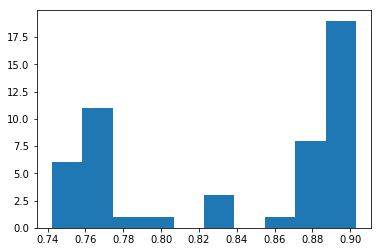

In [197]:
plt.hist(AUC)

(array([  5.,   7.,   3.,   1.,   0.,   1.,   2.,   0.,   8.,  23.]),
 array([ 0.7498832 ,  0.76513958,  0.78039596,  0.79565233,  0.81090871,
         0.82616508,  0.84142146,  0.85667783,  0.87193421,  0.88719059,
         0.90244696]),
 <a list of 10 Patch objects>)

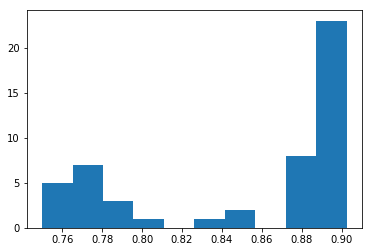

In [198]:
plt.hist(AUC_2)